# Gaussian Process inference in PyMC3
This is the first step in modelling Species occurrence. 
The good news is that MCMC works,
The bad one is that it's computationally intense.


In [4]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps/external_plugins/spystats/')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')
import numpy as np

In [5]:
from spystats import tools

## Simulated data


In [27]:
latent_field = tools.MaternVariogram(sill=1,range_a=0.13,kappa=3.0/2.0)

In [28]:
## Simulations with non squared grid
grid = tools.createGrid(grid_sizex=50,minx=-1,maxx=2,miny=-1,maxy=2,grid_sizey=70)

In [29]:
X,Y,Z = tools.simulatedGaussianFieldAsPcolorMesh(latent_field,grid_sizex=50,minx=0,maxx=1,miny=0,maxy=1,
                                                 grid_sizey=50)

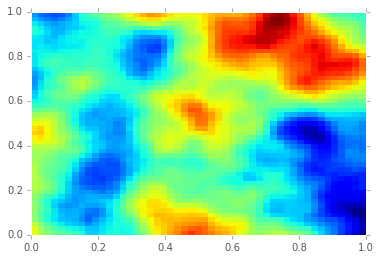

In [30]:
plt.pcolormesh(X,Y,Z)

In [46]:
import pandas as pd
data = pd.DataFrame({'X':X.ravel(),'Y':Y.ravel(),'Z':Z.ravel()})

In [33]:
## Model Specification
import pymc3 as pm


/opt/conda/envs/biospytial/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [44]:
X,Y,Z = tools.simulatedGaussianFieldAsPcolorMesh(latent_field,grid_sizex=50,minx=0,maxx=1,miny=0,maxy=1,
                                                 grid_sizey=50)

In [43]:
sill=1
range_a=0.13
kappa=3.0/2.0
ls = 0.2
tau = 2.0
cov = pm.gp.cov.Matern32(2, range_a,active_dims=[0,1])


In [50]:
K = cov(data[['X','Y']].values).eval()

In [64]:
plt.figure(figsize=(14,4))
dist = pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=1)

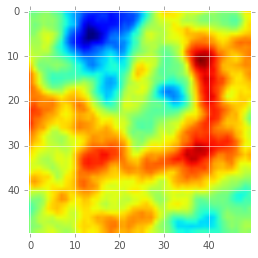

In [66]:
plt.imshow(dist.reshape(50,50))

In [63]:
## Ok, let's try to make some inference

array([-0.07352187, -0.30978285])

In [76]:
import theano.tensor as tt

In [77]:

np.random.seed(1)

# Number of training points
n = 30
X0 = np.sort(3 * np.random.rand(n))[:, None]

# Number of points at which to interpolate
m = 100
X = np.linspace(0, 3, m)[:, None]

# Covariance kernel parameters
noise = 0.1
lengthscale = 0.3
f_scale = 1

cov = f_scale * pm.gp.cov.ExpQuad(1, lengthscale)
K = cov(X0)
K_s = cov(X0, X)
K_noise = K + noise * tt.eye(n)

# Add very slight perturbation to the covariance matrix diagonal to improve numerical stability
K_stable = K + 1e-12 * tt.eye(n)

# Observed data
f = np.random.multivariate_normal(mean=np.zeros(n), cov=K_noise.eval())



## Examine actual posterior distribution

The posterior is analytically tractable so we can compute the posterior mean explicitly. Rather than computing the inverse of the covariance matrix K, we use the numerically stable calculation described Algorithm 2.1 in the book “Gaussian Processes for Machine Learning” (2006) by Rasmussen and Williams, which is available online for free.

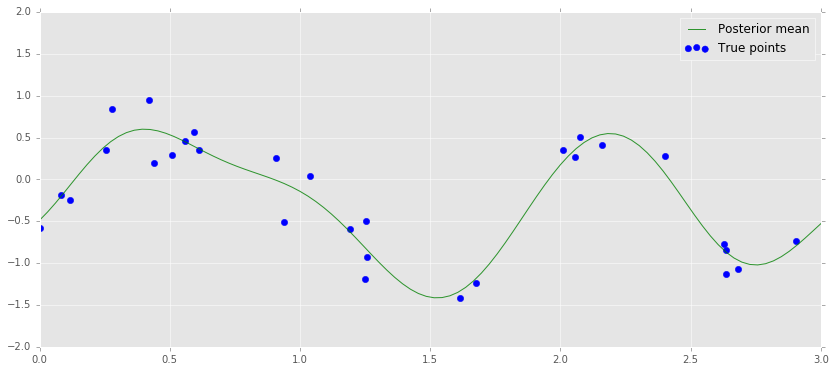

In [78]:
fig, ax = plt.subplots(figsize=(14, 6));
ax.scatter(X0, f, s=40, color='b', label='True points');

# Analytically compute posterior mean
L = np.linalg.cholesky(K_noise.eval())
alpha = np.linalg.solve(L.T, np.linalg.solve(L, f))
post_mean = np.dot(K_s.T.eval(), alpha)

ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');

ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);
ax.legend();

## Examine actual posterior distribution

The posterior is analytically tractable so we can compute the posterior mean explicitly. Rather than computing the inverse of the covariance matrix K, we use the numerically stable calculation described Algorithm 2.1 in the book “Gaussian Processes for Machine Learning” (2006) by Rasmussen and Williams, which is available online for free.

In [79]:
with pm.Model() as model:
    # The actual distribution of f_sample doesn't matter as long as the shape is right since it's only used
    # as a dummy variable for slice sampling with the given prior
    f_sample = pm.Flat('f_sample', shape=(n, ))

    # Likelihood
    y = pm.MvNormal('y', observed=f, mu=f_sample, cov=noise * tt.eye(n), shape=n)

    # Interpolate function values using noisy covariance matrix
    L = tt.slinalg.cholesky(K_noise)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_sample))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace = pm.sample(5000, start=model.test_point, step=[ess_step], progressbar=False, random_seed=1)

ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


## Evaluate posterior fit

The posterior samples are consistent with the analytically derived posterior and behaves how one would expect–narrower near areas with lots of observations and wider in areas with more uncertainty.

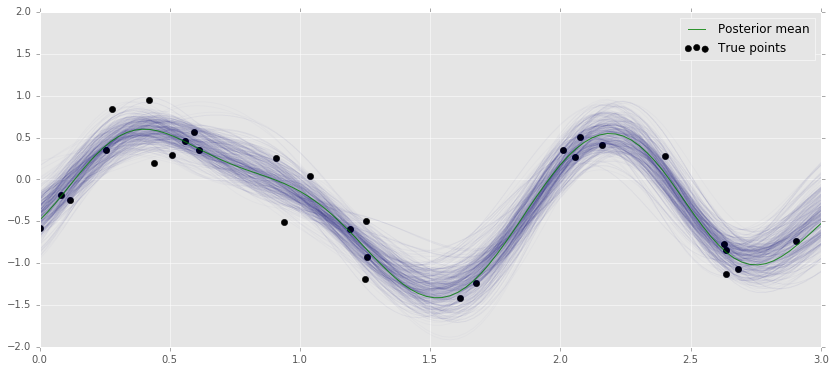

In [80]:
fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X, trace['f_pred'][idx],  alpha=0.02, color='navy')
ax.scatter(X0, f, s=40, color='k', label='True points');
ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');
ax.legend();
ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);

# Clasification
In Gaussian process classification, the likelihood is not normal and thus the posterior is not analytically tractable. The prior is again a multivariate normal with covariance matrix K, and the likelihood is the standard likelihood for logistic regression:
\begin{equation}
L(y | f) = \Pi_n \sigma(y_n, f_n)
\end{equation}

## Generate some example data

We generate random samples from a Gaussian process, assign any points greater than zero to a “positive” class, and assign all other points to a “negative” class.

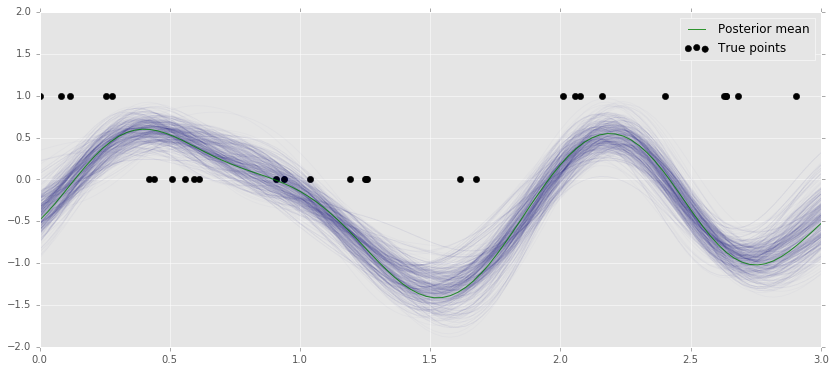

In [82]:
np.random.seed(5)
f = np.random.multivariate_normal(mean=np.zeros(n), cov=K_stable.eval())

# Separate data into positive and negative classes
f[f > 0] = 1
f[f <= 0] = 0

fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X, trace['f_pred'][idx],  alpha=0.02, color='navy')
ax.scatter(X0, f, s=40, color='k', label='True points');
ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');
ax.legend();
ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);



## Sample from posterior distribution

In [84]:
with pm.Model() as model:
    # Again, f_sample is just a dummy variable
    f_sample = pm.Flat('f_sample', shape=n)
    f_transform = pm.invlogit(f_sample)

    # Binomial likelihood
    y = pm.Binomial('y', observed=f, n=np.ones(n), p=f_transform, shape=n)

    # Interpolate function values using noiseless covariance matrix
    L = tt.slinalg.cholesky(K_stable)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_transform))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace = pm.sample(5000, start=model.test_point, step=[ess_step], progressbar=False, random_seed=1)

## Evaluate posterior fit

The posterior looks good, though the fit is, unsurprisingly, erratic outside the range of the observed data.

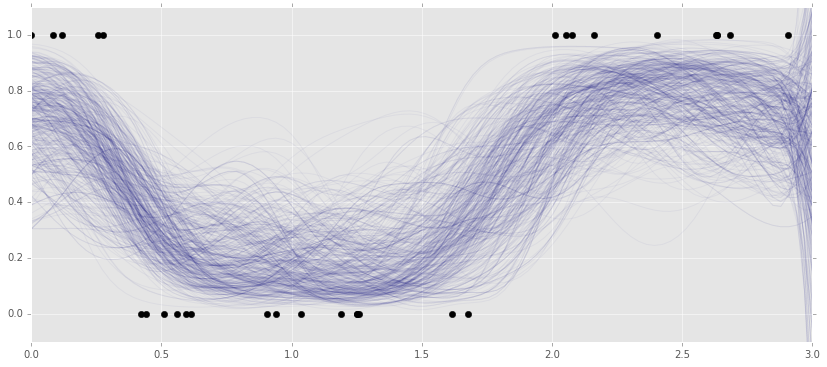

In [85]:
fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X, trace['f_pred'][idx],  alpha=0.04, color='navy')
ax.scatter(X0, f, s=40, color='k');
ax.set_xlim(0, 3);
ax.set_ylim(-0.1, 1.1);